## Automatic removal of black slices from medical images and masks (NIfTI files)

This code removes black slices from 3D medical image files and their associated masks in NIfTI format. Black slices do not contain any relevant information, so their removal saves memory and speeds up processing.


In [2]:
'''
import os
import nibabel as nib

# Ordnerpfad mit deinen .nii-Dateien
folder_path = "F:\\Rawan_Masterarbeit\\data\\upper airways\\images"

# Durchlaufe alle Dateien im Ordner
for filename in os.listdir(folder_path):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        file_path = os.path.join(folder_path, filename)
        
        try:
            # Lade das Bild
            nii_img = nib.load(file_path)
            nii_data = nii_img.get_fdata()
            
            # Anzahl der Slices (Z-Achse)
            num_slices = nii_data.shape[2]
            
            print(f"{filename}: {num_slices} Slices")
        
        except Exception as e:
            print(f"Fehler bei {filename}: {e}")
'''

'\nimport os\nimport nibabel as nib\n\n# Ordnerpfad mit deinen .nii-Dateien\nfolder_path = "F:\\Rawan_Masterarbeit\\data\\upper airways\\images"\n\n# Durchlaufe alle Dateien im Ordner\nfor filename in os.listdir(folder_path):\n    if filename.endswith(".nii") or filename.endswith(".nii.gz"):\n        file_path = os.path.join(folder_path, filename)\n        \n        try:\n            # Lade das Bild\n            nii_img = nib.load(file_path)\n            nii_data = nii_img.get_fdata()\n            \n            # Anzahl der Slices (Z-Achse)\n            num_slices = nii_data.shape[2]\n            \n            print(f"{filename}: {num_slices} Slices")\n        \n        except Exception as e:\n            print(f"Fehler bei {filename}: {e}")\n'

In [5]:
import os
import numpy as np
import nibabel as nib
import nrrd  # pip install pynrrd
import logging
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger().setLevel(logging.DEBUG)

# Hilfsfunktionen

def load_nifti(file_path):
    try:
        return nib.load(file_path)
    except Exception as e:
        logging.error(f"❌ Fehler beim Laden von {file_path}: {e}")
        return None

def save_nifti(data, affine, file_path):
    try:
        nib.save(nib.Nifti1Image(data, affine), file_path)
    except Exception as e:
        logging.error(f"❌ Fehler beim Speichern von {file_path}: {e}")

def load_nrrd(file_path):
    try:
        data, _ = nrrd.read(file_path)
        return np.squeeze(data)
    except Exception as e:
        logging.error(f"❌ Fehler beim Laden von {file_path}: {e}")
        return None

# Schwarze Slices entfernen

def remove_black_slices(image_path, mask_path, tolerance=1e-6):
    image_nifti = load_nifti(image_path)
    mask_data = load_nrrd(mask_path)

    if image_nifti is None or mask_data is None:
        return None, None

    image_data = image_nifti.get_fdata()

    # Boolean-Maske: True = Slice enthält Information
    slice_mask = np.any(mask_data > tolerance, axis=(0, 1))

    # Nur relevante Slices behalten
    filtered_image = image_data[..., slice_mask]
    filtered_mask = mask_data[..., slice_mask]

    return filtered_image, filtered_mask

# Einzelne Bild-Maske Kombination verarbeiten

def process_single_file(image_path, mask_path, output_image_path, output_mask_path, tolerance):
    filtered_image, filtered_mask = remove_black_slices(image_path, mask_path, tolerance)

    if filtered_image is not None and filtered_image.shape[2] > 0:
        affine = load_nifti(image_path).affine
        save_nifti(filtered_image, affine, output_image_path)
        save_nifti(filtered_mask, affine, output_mask_path)

# Hauptverarbeitung

def process_images_and_masks_parallel(images_dir, masks_dir, output_images_dir, output_masks_dir, tolerance=1e-6):
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_masks_dir, exist_ok=True)

    label_folders = [f for f in os.listdir(masks_dir) if f.startswith("label_")]

    with ThreadPoolExecutor() as executor, tqdm(total=len(label_folders)) as progress:
        futures = []
        for label_folder in label_folders:
            label_path = os.path.join(masks_dir, label_folder)
            mask_path = os.path.join(label_path, "Segmentation.seg.nrrd")

            rec_number = label_folder.replace("label_", "")

            # Suche nach .nii oder .nii.gz
            nii_path = os.path.join(images_dir, f"rec_{rec_number}.nii")
            nii_gz_path = os.path.join(images_dir, f"rec_{rec_number}.nii.gz")

            if os.path.exists(nii_path):
                image_path = nii_path
            elif os.path.exists(nii_gz_path):
                image_path = nii_gz_path
            else:
                logging.warning(f"⚠️ Kein Bild gefunden für {label_folder}")
                progress.update(1)
                continue

            output_image_path = os.path.join(output_images_dir, os.path.basename(image_path))
            output_mask_path = os.path.join(output_masks_dir, f"label_{rec_number}.nii.gz")

            logging.debug(f"✅ Verarbeite: {image_path} und {mask_path}")

            futures.append(executor.submit(
                process_single_file, image_path, mask_path, output_image_path, output_mask_path, tolerance
            ))

        for future in futures:
            future.result()
            progress.update(1)

# Main

def main():
    images_dir = r"F:/Rawan_Masterarbeit/data/upper_airways/images"
    masks_dir = r"F:/Rawan_Masterarbeit/data/upper_airways/masks"
    output_images_dir = r"F:/Rawan_Masterarbeit/data/upper_airways/filtered_images"
    output_masks_dir = r"F:/Rawan_Masterarbeit/data/upper_airways/filtered_masks"

    process_images_and_masks_parallel(images_dir, masks_dir, output_images_dir, output_masks_dir)

if __name__ == "__main__":
    main()


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]2025-04-15 15:19:37,698 - DEBUG - ✅ Verarbeite: F:/Rawan_Masterarbeit/data/upper_airways/images\rec_1.nii.gz und F:/Rawan_Masterarbeit/data/upper_airways/masks\label_1\Segmentation.seg.nrrd
2025-04-15 15:19:37,713 - DEBUG - ✅ Verarbeite: F:/Rawan_Masterarbeit/data/upper_airways/images\rec_10.nii.gz und F:/Rawan_Masterarbeit/data/upper_airways/masks\label_10\Segmentation.seg.nrrd
2025-04-15 15:19:37,723 - DEBUG - ✅ Verarbeite: F:/Rawan_Masterarbeit/data/upper_airways/images\rec_11.nii.gz und F:/Rawan_Masterarbeit/data/upper_airways/masks\label_11\Segmentation.seg.nrrd
2025-04-15 15:19:37,738 - DEBUG - ✅ Verarbeite: F:/Rawan_Masterarbeit/data/upper_airways/images\rec_13.nii.gz und F:/Rawan_Masterarbeit/data/upper_airways/masks\label_13\Segmentation.seg.nrrd
2025-04-15 15:19:37,741 - DEBUG - ✅ Verarbeite: F:/Rawan_Masterarbeit/data/upper_airways/images\rec_14.nii.gz und F

In [3]:
images_dir = r"F:/Rawan_Masterarbeit/data/upper_airways/images"
print("Dateien im Ordner:")
for f in sorted(os.listdir(images_dir)):
    print(f)


Dateien im Ordner:
rec_1.nii.gz
rec_10.nii.gz
rec_11.nii.gz
rec_13.nii.gz
rec_14.nii.gz
rec_15.nii.gz
rec_16.nii.gz
rec_17.nii.gz
rec_18.nii.gz
rec_19.nii.gz
rec_2.nii.gz
rec_20.nii.gz
rec_21.nii.gz
rec_22.nii.gz
rec_23.nii.gz
rec_24.nii.gz
rec_25.nii.gz
rec_26.nii.gz
rec_27.nii.gz
rec_28.nii.gz
rec_29.nii.gz
rec_30.nii.gz
rec_31.nii.gz
rec_32.nii.gz
rec_33.nii.gz
rec_34.nii.gz
rec_35.nii.gz
rec_36.nii.gz
rec_37.nii.gz
rec_5.nii.gz
rec_7.nii.gz
rec_8.nii.gz


In [4]:
test_path = os.path.join(images_dir, "rec_1.nii")
print("Testpfad:", test_path)
print("Existiert:", os.path.exists(test_path))


Testpfad: F:/Rawan_Masterarbeit/data/upper_airways/images\rec_1.nii
Existiert: False


In [6]:
import os
import nibabel as nib

# Ordnerpfad mit deinen .nii-Dateien
folder_path = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_images"

# Durchlaufe alle Dateien im Ordner
for filename in os.listdir(folder_path):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        file_path = os.path.join(folder_path, filename)
        
        try:
            # Lade das Bild
            nii_img = nib.load(file_path)
            nii_data = nii_img.get_fdata()
            
            # Anzahl der Slices (Z-Achse)
            num_slices = nii_data.shape[2]
            
            print(f"{filename}: {num_slices} Slices")
        
        except Exception as e:
            print(f"Fehler bei {filename}: {e}")


rec_1.nii.gz: 32 Slices
rec_17.nii.gz: 69 Slices
rec_14.nii.gz: 63 Slices
rec_11.nii.gz: 57 Slices
rec_10.nii.gz: 57 Slices
rec_13.nii.gz: 70 Slices
rec_16.nii.gz: 68 Slices
rec_18.nii.gz: 65 Slices
rec_15.nii.gz: 114 Slices
rec_19.nii.gz: 66 Slices
rec_20.nii.gz: 69 Slices
rec_2.nii.gz: 47 Slices
rec_22.nii.gz: 66 Slices
rec_23.nii.gz: 68 Slices
rec_26.nii.gz: 60 Slices
rec_21.nii.gz: 114 Slices
rec_24.nii.gz: 68 Slices
rec_27.nii.gz: 57 Slices
rec_25.nii.gz: 127 Slices
rec_31.nii.gz: 58 Slices
rec_29.nii.gz: 108 Slices
rec_32.nii.gz: 86 Slices
rec_35.nii.gz: 67 Slices
rec_28.nii.gz: 109 Slices
rec_36.nii.gz: 60 Slices
rec_37.nii.gz: 69 Slices
rec_5.nii.gz: 74 Slices
rec_34.nii.gz: 197 Slices
rec_8.nii.gz: 63 Slices
rec_33.nii.gz: 77 Slices
rec_7.nii.gz: 155 Slices
rec_30.nii.gz: 378 Slices


## Fortschrittliche medizinische Bildsegmentierung mit MedSAM und Bounding-Box-Optimierung

In [1]:
''' 
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry
from skimage import transform
import nibabel as nib
from scipy.ndimage import label
import logging
from concurrent.futures import ThreadPoolExecutor

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Visualisierungsfunktionen
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])  # Gelb mit Transparenz
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

# Inferenzfunktion
@torch.no_grad()
def medsam_inference_single_box(medsam_model, img_embed, box_1024, H, W):
    logging.debug(f"Inference gestartet für Box: {box_1024}")
    box_torch = torch.as_tensor(box_1024[None, :], dtype=torch.float, device=img_embed.device)
    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )
    low_res_pred = torch.sigmoid(low_res_logits)
    low_res_pred = torch.nn.functional.interpolate(
        low_res_pred, size=(H, W), mode="bilinear", align_corners=False
    )
    low_res_pred = low_res_pred.squeeze().cpu().numpy()
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    logging.debug(f"Segmentierung erstellt: {medsam_seg.shape}")
    return medsam_seg

# Bounding-Box-Erkennung
def get_multiple_bounding_boxes(mask_slice):
    labeled_mask, num_features = label(mask_slice > 0)
    bounding_boxes = []
    for region in range(1, num_features + 1):
        region_coords = np.argwhere(labeled_mask == region)
        y_min, x_min = region_coords.min(axis=0)
        y_max, x_max = region_coords.max(axis=0)
        bounding_boxes.append([x_min, y_min, x_max, y_max])
    logging.debug(f"Gefundene Bounding Boxes: {bounding_boxes}")
    return bounding_boxes

# Verarbeitung von Bildern und Masken
def process_images_and_masks_with_resume(images_dir, masks_dir, output_dir, resume_file=None, resume_slice=None):
    resume = resume_file is None
    os.makedirs(output_dir, exist_ok=True)

    for mask_file in sorted(os.listdir(masks_dir)):
        mask_path = os.path.join(masks_dir, mask_file)
        image_filename = mask_file.replace("label_", "rec_").replace(".nii.gz", ".nii.gz")
        image_path = os.path.join(images_dir, image_filename)

        if not os.path.exists(image_path):
            logging.warning(f"Fehlendes Bild für Maske: {mask_file} (erwartet: {image_filename})")
            continue

        if not resume and mask_file == resume_file:
            resume = True

        if not resume:
            continue

        nifti_image = nib.load(image_path)
        nifti_mask = nib.load(mask_path)

        image_data = nifti_image.get_fdata()
        mask_data = nifti_mask.get_fdata()

        total_slices = image_data.shape[2]
        slice_start = resume_slice if mask_file == resume_file and resume_slice is not None else 0

        for slice_idx in range(slice_start, total_slices):
            logging.info(f"Verarbeite Slice {slice_idx} für Datei {mask_file}")
            image_slice = image_data[:, :, slice_idx]
            mask_slice = mask_data[:, :, slice_idx]

            if np.sum(mask_slice) == 0:
                logging.debug(f"Leere Maske in Slice {slice_idx}")
                continue

            bounding_boxes = get_multiple_bounding_boxes(mask_slice)
            if not bounding_boxes:
                logging.debug(f"Keine Bounding Boxes in Slice {slice_idx}")
                continue

            H, W = image_slice.shape
            resized_image = transform.resize(
                image_slice, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
            )
            normalized_image = (resized_image - resized_image.min()) / max(resized_image.max() - resized_image.min(), 1e-8)
            image_rgb = np.stack([normalized_image] * 3, axis=-1)
            boxes_1024 = np.array(bounding_boxes) / np.array([W, H, W, H]) * 1024
            image_tensor = torch.tensor(image_rgb).float().permute(2, 0, 1).unsqueeze(0).to(device)

            combined_seg = np.zeros((1024, 1024), dtype=np.uint8)
            with torch.no_grad():
                image_embedding = medsam_model.image_encoder(image_tensor)
                for box_1024 in boxes_1024:
                    medsam_seg = medsam_inference_single_box(medsam_model, image_embedding, box_1024, 1024, 1024)
                    combined_seg = np.maximum(combined_seg, medsam_seg)

            visualization_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_visualization.png")
            segmentation_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_segmentation.png")

            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(resized_image, cmap="gray")
            for box in boxes_1024:
                show_box(box, ax[0])
            ax[0].set_title(f"Original Slice {slice_idx} mit Bounding Boxes")

            ax[1].imshow(resized_image, cmap="gray")
            show_mask(combined_seg, ax[1])
            ax[1].set_title(f"Segmentierungen Slice {slice_idx}")

            plt.savefig(visualization_file)
            plt.close(fig)
            plt.imsave(segmentation_file, combined_seg, cmap="gray")

            logging.info(f"Slice {slice_idx} gespeichert: {visualization_file}")

        resume_slice = None

# Hauptparameter
images_dir = "data/upper_airways/filtered_images"
masks_dir = "data/upper_airways/filtered_masks"
output_dir = "data/upper_airways/segmentation_results"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwendetes Gerät: {device}")

# Modell laden
MedSAM_CKPT_PATH = "Checkpoint/sam_vit_b_01ec64.pth"
medsam_model = sam_model_registry["vit_b"](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

# Verarbeitung starten
process_images_and_masks_with_resume(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="label_1.nii.gz",  # z. B. um bei einer bestimmten Datei weiterzumachen
    resume_slice=0
)
''' 

' \nimport os\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport torch\nfrom segment_anything import sam_model_registry\nfrom skimage import transform\nimport nibabel as nib\nfrom scipy.ndimage import label\nimport logging\nfrom concurrent.futures import ThreadPoolExecutor\n\n# Logging konfigurieren\nlogging.basicConfig(level=logging.INFO, format=\'%(asctime)s - %(levelname)s - %(message)s\')\n\n# Visualisierungsfunktionen\ndef show_mask(mask, ax, random_color=False):\n    if random_color:\n        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)\n    else:\n        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])  # Gelb mit Transparenz\n    h, w = mask.shape[-2:]\n    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)\n    ax.imshow(mask_image)\n\ndef show_box(box, ax):\n    x0, y0 = box[0], box[1]\n    w, h = box[2] - box[0], box[3] - box[1]\n    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2

In [1]:
'''
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from scipy.ndimage import label
import torch
import torch.nn.functional as F
from segment_anything import sam_model_registry
from tqdm import tqdm
import logging
import gc  # für Speicherbereinigung

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Visualisierungsfunktionen
def show_mask(mask, ax, random_color=False):
    color = np.random.rand(3) if random_color else np.array([251/255, 252/255, 30/255])
    mask_img = np.zeros((*mask.shape, 4))
    mask_img[mask > 0] = np.append(color, 0.6)
    ax.imshow(mask_img)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor="none", lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024[None, :], dtype=torch.float, device=img_embed.device)
    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )
    low_res_pred = torch.sigmoid(low_res_logits)
    low_res_pred = F.interpolate(low_res_pred, size=(H, W), mode="bilinear", align_corners=False)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()
    return (low_res_pred > 0.5).astype(np.uint8)

# Bounding Box Finder (mehrere Boxen)
def get_multiple_bounding_boxes(mask_slice):
    labeled_mask, num_features = label(mask_slice > 0)
    boxes = []
    for i in range(1, num_features + 1):
        coords = np.argwhere(labeled_mask == i)
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        boxes.append([x_min, y_min, x_max, y_max])
    return boxes

# Verarbeitung
def process_images_and_masks(images_dir, masks_dir, output_dir, resume_file=None, resume_slice=None):
    os.makedirs(output_dir, exist_ok=True)
    resume = resume_file is None
    mask_files = sorted(os.listdir(masks_dir))

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as file_bar:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_filename = mask_file.replace("label_", "rec_").replace(".nii.gz", ".nii.gz")
            image_path = os.path.join(images_dir, image_filename)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild: {image_filename}")
                file_bar.update(1)
                continue

            if not resume and mask_file == resume_file:
                resume = True
            if not resume:
                file_bar.update(1)
                continue

            image = nib.load(image_path).get_fdata()
            mask = nib.load(mask_path).get_fdata()
            total_slices = image.shape[2]
            start_slice = resume_slice if mask_file == resume_file and resume_slice else 0

            with tqdm(total=total_slices - start_slice, desc=f"{mask_file}", unit="Slice") as slice_bar:
                for idx in range(start_slice, total_slices):
                    img_slice = image[:, :, idx]
                    mask_slice = mask[:, :, idx]

                    if np.sum(mask_slice) == 0:
                        slice_bar.update(1)
                        continue

                    boxes = get_multiple_bounding_boxes(mask_slice)
                    if not boxes:
                        slice_bar.update(1)
                        continue

                    H, W = img_slice.shape
                    resized = transform.resize(img_slice, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True)
                    # norm = (resized - resized.min()) / max(resized.max() - resized.min(), 1e-8)
                    norm = resized / 255.0
                    img_rgb = np.stack([norm]*3, axis=-1)
                    img_tensor = torch.tensor(img_rgb).float().permute(2, 0, 1).unsqueeze(0).to(device)
                    box_array = np.array(boxes) / np.array([W, H, W, H]) * 1024

                    with torch.no_grad():
                        embedding = medsam_model.image_encoder(img_tensor)
                        combined = np.zeros((1024, 1024), dtype=np.uint8)
                        for box in box_array:
                            seg = medsam_inference(medsam_model, embedding, box, 1024, 1024)
                            combined = np.maximum(combined, seg)

                    # Speichern
                    vis_path = os.path.join(output_dir, f"{mask_file}_slice_{idx}_vis.png")
                    seg_path = os.path.join(output_dir, f"{mask_file}_slice_{idx}_seg.png")

                    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                    ax[0].imshow(resized, cmap="gray")
                    for box in box_array:
                        show_box(box, ax[0])
                    ax[0].set_title(f"Slice {idx} mit Boxen")

                    ax[1].imshow(resized, cmap="gray")
                    show_mask(combined, ax[1])
                    ax[1].set_title("Segmentierung")

                    plt.savefig(vis_path)
                    plt.close(fig)
                    plt.imsave(seg_path, combined, cmap="gray")

                    del img_tensor, embedding, combined
                    gc.collect()
                    slice_bar.update(1)
            file_bar.update(1)

# Geräte und Modell laden
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwendetes Gerät: {device}")

MedSAM_CKPT_PATH = "Checkpoint/sam_vit_b_01ec64.pth"
medsam_model = sam_model_registry["vit_b"](checkpoint=MedSAM_CKPT_PATH).to(device).eval()

# Starte Verarbeitung
process_images_and_masks(
    images_dir="data/upper_airways/filtered_images",
    masks_dir="data/upper_airways/filtered_masks",
    output_dir="data/upper_airways/segmentation_results",
    resume_file="label_29.nii.gz",
    resume_slice=0
)
''' 

'\nimport os\nimport numpy as np\nimport nibabel as nib\nimport matplotlib.pyplot as plt\nfrom skimage import transform\nfrom scipy.ndimage import label\nimport torch\nimport torch.nn.functional as F\nfrom segment_anything import sam_model_registry\nfrom tqdm import tqdm\nimport logging\nimport gc  # für Speicherbereinigung\n\n# Logging konfigurieren\nlogging.basicConfig(level=logging.INFO, format=\'%(asctime)s - %(levelname)s - %(message)s\')\n\n# Visualisierungsfunktionen\ndef show_mask(mask, ax, random_color=False):\n    color = np.random.rand(3) if random_color else np.array([251/255, 252/255, 30/255])\n    mask_img = np.zeros((*mask.shape, 4))\n    mask_img[mask > 0] = np.append(color, 0.6)\n    ax.imshow(mask_img)\n\ndef show_box(box, ax):\n    x0, y0 = box[0], box[1]\n    w, h = box[2] - box[0], box[3] - box[1]\n    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor="none", lw=2))\n\n@torch.no_grad()\ndef medsam_inference(medsam_model, img_embed, box_1024, H,

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
import torch
import torch.nn.functional as F
from segment_anything import sam_model_registry
import gc
from tqdm import tqdm
import logging

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# %% Visualisierungsfunktionen
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])  # Gelb mit Transparenz
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

def get_bounding_boxes_from_mask(mask):
    labeled_mask = label(mask)
    boxes = []
    for region in regionprops(labeled_mask):
        minr, minc, maxr, maxc = region.bbox
        boxes.append([minc, minr, maxc, maxr])  # [x_min, y_min, x_max, y_max]
    return boxes

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)
    low_res_pred = F.interpolate(low_res_pred, size=(H, W), mode="bilinear", align_corners=False)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

# %% Gerät definieren
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

# %% Modell laden
MedSAM_CKPT_PATH = "Checkpoint/sam_vit_b_01ec64.pth"
medsam_model = sam_model_registry["vit_b"](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()
logging.info("MedSAM Modell erfolgreich geladen.")

# %% Segmentierung mit Wiederaufnahme und mehreren Boxen
def process_images_and_masks_with_resume(images_dir, masks_dir, output_dir, resume_file=None, resume_slice=None):
    resume = resume_file is None
    mask_files = sorted(os.listdir(masks_dir))

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1)
                continue

            if not resume and mask_file == resume_file:
                resume = True
            if not resume:
                progress.update(1)
                continue

            nifti_image = nib.load(image_path)
            nifti_mask = nib.load(mask_path)
            image_data = nifti_image.get_fdata()
            mask_data = nifti_mask.get_fdata()
            total_slices = image_data.shape[2]
            slice_start = resume_slice if mask_file == resume_file and resume_slice is not None else 0

            with tqdm(total=total_slices, desc=f"Slices in {mask_file}", unit="Slice") as slice_progress:
                for slice_idx in range(slice_start, total_slices):
                    logging.info(f"Verarbeite Slice {slice_idx} für Datei {mask_file}")
                    image_slice = image_data[:, :, slice_idx]
                    mask_slice = mask_data[:, :, slice_idx]

                    if np.sum(mask_slice) == 0:
                        slice_progress.update(1)
                        continue

                    boxes = get_bounding_boxes_from_mask(mask_slice)
                    H, W = image_slice.shape
                    resized_image = transform.resize(image_slice, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True)
                    # normalized_image = (resized_image - resized_image.min()) / max(resized_image.max() - resized_image.min(), 1e-8)
                    normalized_image = resized_image / 255.0
                    image_rgb = np.stack([normalized_image] * 3, axis=-1)
                    image_tensor = torch.tensor(image_rgb).float().permute(2, 0, 1).unsqueeze(0).to(device)

                    with torch.no_grad():
                        image_embedding = medsam_model.image_encoder(image_tensor)
                        combined_seg = np.zeros((1024, 1024), dtype=np.uint8)

                        for box in boxes:
                            box_np = np.array([box])
                            box_1024 = box_np / np.array([W, H, W, H]) * 1024
                            medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, 1024, 1024)
                            combined_seg = np.maximum(combined_seg, medsam_seg)

                    visualization_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_visualization.png")
                    seg_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_segmentation.png")

                    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                    ax[0].imshow(resized_image, cmap="gray")
                    for box in boxes:
                        box_1024 = np.array(box) / np.array([W, H, W, H]) * 1024
                        show_box(box_1024, ax[0])
                    ax[0].set_title(f"Original Slice {slice_idx} mit Bounding Boxes")
                    ax[1].imshow(resized_image, cmap="gray")
                    show_mask(combined_seg, ax[1])
                    ax[1].set_title(f"Segmentierung Slice {slice_idx}")
                    plt.savefig(visualization_file)
                    plt.close(fig)

                    plt.imsave(seg_file, combined_seg, cmap="gray")

                    del image_tensor, image_embedding, medsam_seg
                    gc.collect()
                    slice_progress.update(1)

            logging.info(f"Fertig mit Datei {mask_file}")
            progress.update(1)

# %% Verzeichnisse definieren und starten
images_dir = "data/upper_airways/filtered_images"
masks_dir = "data/upper_airways/filtered_masks"
output_dir = "data/upper_airways/segmentation_results_18_06"
os.makedirs(output_dir, exist_ok=True)

process_images_and_masks_with_resume(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="atm_037.nii.gz",
    resume_slice=20
)


2025-06-25 15:17:07,165 - INFO - Verwende Gerät: cpu
2025-06-25 15:17:12,254 - INFO - MedSAM Modell erfolgreich geladen.
Slices in atm_037.nii.gz:   0%|                                                              | 0/69 [00:00<?, ?Slice/s]2025-06-25 15:17:13,861 - INFO - Verarbeite Slice 20 für Datei atm_037.nii.gz

Slices in atm_037.nii.gz:   1%|▊                                                     | 1/69 [00:42<47:45, 42.14s/Slice]2025-06-25 15:17:56,005 - INFO - Verarbeite Slice 21 für Datei atm_037.nii.gz

Slices in atm_037.nii.gz:   3%|█▌                                                    | 2/69 [01:12<39:21, 35.25s/Slice]2025-06-25 15:18:26,435 - INFO - Verarbeite Slice 22 für Datei atm_037.nii.gz

Slices in atm_037.nii.gz:   4%|██▎                                                   | 3/69 [01:50<40:01, 36.38s/Slice]2025-06-25 15:19:04,176 - INFO - Verarbeite Slice 23 für Datei atm_037.nii.gz

Slices in atm_037.nii.gz:   6%|███▏                                                  | 

In [1]:
# -*- coding: utf-8 -*-
import os
import json
import time
import csv
import gc
import logging
from typing import Optional, Tuple

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
import torch
import torch.nn.functional as F
from segment_anything import sam_model_registry
import pandas as pd
from tqdm import tqdm

# ========================= Logging =========================
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# =================== Visualisierungsfunktionen ===================
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])  # Gelb mit Transparenz
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

def get_bounding_boxes_from_mask(mask):
    labeled_mask = label(mask)
    boxes = []
    for region in regionprops(labeled_mask):
        minr, minc, maxr, maxc = region.bbox
        boxes.append([minc, minr, maxc, maxr])  # [x_min, y_min, x_max, y_max]
    return boxes

# =================== MedSAM Inferenz ===================
@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)
    low_res_pred = F.interpolate(low_res_pred, size=(H, W), mode="bilinear", align_corners=False)
    low_res_pred = low_res_pred.squeeze().detach().cpu().numpy()
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

# =================== Gerät & Modell ===================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

MedSAM_CKPT_PATH = "Checkpoint/sam_vit_b_01ec64.pth"
medsam_model = sam_model_registry["vit_b"](checkpoint=MedSAM_CKPT_PATH).to(device).eval()
logging.info("MedSAM Modell erfolgreich geladen.")

# =================== Helpers: Zeitformat, CSV-Summe, Runtime-State ===================
def _fmt(sec: float) -> str:
    h, r = divmod(sec, 3600)
    m, s = divmod(r, 60)
    return f"{int(h):02d}:{int(m):02d}:{s:05.2f}"

def _sum_seconds_from_csv(csv_path: str) -> float:
    if not os.path.exists(csv_path):
        return 0.0
    total = 0.0
    try:
        with open(csv_path, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            if not reader.fieldnames or "seconds" not in reader.fieldnames:
                return 0.0
            for row in reader:
                try:
                    total += float(row["seconds"])
                except Exception:
                    continue
    except Exception as e:
        logging.warning(f"Konnte CSV nicht auswerten ({csv_path}): {e}")
    return total

def _load_runtime_state(state_path: str) -> dict:
    if os.path.exists(state_path):
        try:
            with open(state_path, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception as e:
            logging.warning(f"Konnte Runtime-State nicht lesen: {e}")
    return {"sessions": [], "total_elapsed_sec": 0.0}

def _save_runtime_state(state_path: str, state: dict):
    with open(state_path, "w", encoding="utf-8") as f:
        json.dump(state, f, indent=2)

def save_resume_state(checkpoint_path: str, filename: str, slice_idx: int):
    state = {"resume_file": filename, "resume_slice": slice_idx}
    with open(checkpoint_path, "w", encoding="utf-8") as f:
        json.dump(state, f)

def load_resume_state(checkpoint_path: str) -> Tuple[Optional[str], Optional[int]]:
    if os.path.exists(checkpoint_path):
        try:
            with open(checkpoint_path, "r", encoding="utf-8") as f:
                state = json.load(f)
            return state.get("resume_file"), state.get("resume_slice")
        except Exception as e:
            logging.warning(f"Checkpoint konnte nicht gelesen werden: {e}")
    return None, None

def time_run_accumulate(func, state_path: str, seed_timing_csv: str, *args, **kwargs):
    """
    Führt func aus, misst Laufzeit des aktuellen Runs (Wall-Clock) und akkumuliert in state_path.
    Loggt am Ende zusätzlich die SUMME der 'seconds' aus seed_timing_csv.
    """
    state = _load_runtime_state(state_path)
    start = time.perf_counter()
    start_wall = time.time()
    logging.info("==== Starte Laufzeitmessung (akkumuliert) ====")
    try:
        return func(*args, **kwargs)
    finally:
        elapsed = time.perf_counter() - start
        end_wall = time.time()
        state["sessions"].append({"start": start_wall, "end": end_wall, "elapsed_sec": elapsed})
        state["total_elapsed_sec"] = float(state.get("total_elapsed_sec", 0.0)) + float(elapsed)
        _save_runtime_state(state_path, state)

        msg1 = f"Aktueller Run: {_fmt(elapsed)} | Akkumuliert (Wall-Clock): {_fmt(state['total_elapsed_sec'])}"
        logging.info(msg1)

        total_csv_sec = _sum_seconds_from_csv(seed_timing_csv)
        msg2 = f"Akkumulierte Gesamtlaufzeit (aus CSV, alle Neustarts): {_fmt(total_csv_sec)}"
        logging.info(msg2)

        with open("runtime_log.txt", "a", encoding="utf-8") as f:
            f.write(msg1 + "\n")
            f.write(msg2 + "\n")

# =================== Pipeline mit Resume & Timing ===================
def process_images_and_masks_with_resume(
    images_dir: str,
    masks_dir: str,
    output_dir: str,
    checkpoint_path: str,
    timing_csv: str,
    resume_file: Optional[str] = None,
    resume_slice: Optional[int] = None,
    use_auto_resume: bool = True,
):
    """
    - Liest Bilder/Maksen (gleiche Dateinamen) und segmentiert pro Slice mit MedSAM (mehrere Bounding Boxes möglich).
    - Speichert Overlay und binäre Maske als PNG (ein Ordner).
    - Schreibt VOR jedem Slice einen Resume-Checkpoint (Datei & Slice).
    - Hängt pro Slice die Laufzeit (Inferenz + Speichern) an timing_csv an.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Auto-Resume laden
    if use_auto_resume and (resume_file is None and resume_slice is None):
        cf, cs = load_resume_state(checkpoint_path)
        if cf is not None:
            logging.info(f"Automatischer Resume → Datei={cf}, Slice={cs}")
            resume_file, resume_slice = cf, cs

    # timing CSV initialisieren
    if not os.path.exists(timing_csv):
        with open(timing_csv, "w", newline="", encoding="utf-8") as fcsv:
            csv.writer(fcsv).writerow(["file", "slice_idx", "seconds"])

    resume_armed = resume_file is None
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith((".nii", ".nii.gz"))])

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1)
                continue

            if not resume_armed:
                if mask_file == resume_file:
                    resume_armed = True
                else:
                    progress.update(1)
                    continue

            # NIfTI laden
            try:
                nifti_image = nib.load(image_path)
                nifti_mask  = nib.load(mask_path)
                image_data = nifti_image.get_fdata()
                mask_data  = nifti_mask.get_fdata()
            except Exception as e:
                logging.error(f"Fehler beim Laden von {mask_file}: {e}")
                progress.update(1)
                continue

            total_slices = int(image_data.shape[2])
            slice_start = resume_slice if (mask_file == resume_file and resume_slice is not None) else 0

            with tqdm(total=total_slices, desc=f"Slices in {mask_file}", unit="Slice") as slice_progress:
                for slice_idx in range(slice_start, total_slices):
                    t0 = time.perf_counter()
                    try:
                        # Checkpoint VOR der Bearbeitung schreiben (für Auto-Resume)
                        save_resume_state(checkpoint_path, mask_file, slice_idx)

                        image_slice = image_data[:, :, slice_idx]
                        mask_slice  = mask_data[:, :, slice_idx]

                        if np.sum(mask_slice) == 0:
                            # Leere GT → trotzdem Zeit erfassen (nahe 0) und fortfahren
                            elapsed_slice = time.perf_counter() - t0
                            with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                                csv.writer(fcsv).writerow([mask_file, slice_idx, f"{elapsed_slice:.4f}"])
                            slice_progress.update(1)
                            continue

                        boxes = get_bounding_boxes_from_mask(mask_slice)
                        H, W = image_slice.shape

                        # Resize + Normalisierung
                        resized_image = transform.resize(
                            image_slice, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
                        )
                        # Falls deine Daten nicht im 0..255 Bereich liegen, ist Min-Max robuster:
                        # normalized_image = (resized_image - resized_image.min()) / max(resized_image.ptp(), 1e-8)
                        normalized_image = resized_image / 255.0
                        image_rgb = np.stack([normalized_image] * 3, axis=-1)
                        image_tensor = torch.tensor(image_rgb).float().permute(2, 0, 1).unsqueeze(0).to(device)

                        with torch.no_grad():
                            image_embedding = medsam_model.image_encoder(image_tensor)
                            combined_seg = np.zeros((1024, 1024), dtype=np.uint8)
                            for box in boxes:
                                box_np = np.array([box])
                                box_1024 = box_np / np.array([W, H, W, H]) * 1024
                                medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, 1024, 1024)
                                combined_seg = np.maximum(combined_seg, medsam_seg)

                        # Speichern
                        visualization_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_visualization.png")
                        seg_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_segmentation.png")

                        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                        ax[0].imshow(resized_image, cmap="gray")
                        for box in boxes:
                            box_1024 = np.array(box) / np.array([W, H, W, H]) * 1024
                            show_box(box_1024, ax[0])
                        ax[0].set_title(f"Original Slice {slice_idx} mit Bounding Boxes")
                        ax[1].imshow(resized_image, cmap="gray")
                        show_mask(combined_seg, ax[1])
                        ax[1].set_title(f"Segmentierung Slice {slice_idx}")
                        plt.savefig(visualization_file)
                        plt.close(fig)

                        plt.imsave(seg_file, combined_seg, cmap="gray")

                        # Cleanup
                        del image_tensor, image_embedding, medsam_seg
                        gc.collect()

                    except Exception as e:
                        logging.error(f"Fehler bei {mask_file} Slice {slice_idx}: {e}")
                    finally:
                        # Slice-Zeit erfassen
                        elapsed_slice = time.perf_counter() - t0
                        with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                            csv.writer(fcsv).writerow([mask_file, slice_idx, f"{elapsed_slice:.4f}"])
                        slice_progress.update(1)

            logging.info(f"Fertig mit Datei {mask_file}")
            progress.update(1)

    # Fertig → Checkpoint löschen
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)
        logging.info("Checkpoint entfernt (Pipeline abgeschlossen).")

# =================== AUSFÜHRUNG ===================
if __name__ == "__main__":
    # Verzeichnisse
    images_dir = "data/upper_airways/filtered_images"
    masks_dir  = "data/upper_airways/filtered_masks"
    output_dir = "data/upper_airways/MedSAM_Segmentation_results_with_run_time"  # ein Ordner für alles
    os.makedirs(output_dir, exist_ok=True)

    # Runtime/Resume Artefakte
    checkpoint_path = os.path.join(output_dir, "resume_checkpoint.json")
    timing_csv      = os.path.join(output_dir, "timing_per_slice.csv")
    runtime_state   = os.path.join(output_dir, "runtime_state.json")

    # Manuelles Resume (optional). Wenn None/None → Auto-Resume via JSON.
    manual_resume_file  = None   # oder None
    manual_resume_slice = None                 # oder None

    # Lauf starten (Wall-Clock akkumuliert + CSV-basierte Summe)
    time_run_accumulate(
        process_images_and_masks_with_resume,
        runtime_state,               # state_path
        seed_timing_csv=timing_csv,  # für Summen-Log am Ende
        images_dir=images_dir,
        masks_dir=masks_dir,
        output_dir=output_dir,
        checkpoint_path=checkpoint_path,
        timing_csv=timing_csv,       # Pflichtargument für Pipeline
        resume_file=manual_resume_file,
        resume_slice=manual_resume_slice,
        use_auto_resume=True,
    )

    # ======= Timing-Zusammenfassung (pandas) =======
    if os.path.exists(timing_csv):
        df = pd.read_csv(timing_csv)
        df['seconds'] = pd.to_numeric(df['seconds'], errors='coerce')

        total_seconds = df['seconds'].sum()
        total_minutes = total_seconds / 60
        total_hours   = total_seconds / 3600

        num_rows   = len(df)  # = Anzahl erfasster Slices (mit/ohne Inhalt)
        avg_sec    = df['seconds'].mean()
        avg_min    = avg_sec / 60
        min_sec    = df['seconds'].min()
        max_sec    = df['seconds'].max()
        median_sec = df['seconds'].median()

        print("==== Timing Summary ====")
        print(f"Slices verarbeitet : {num_rows}")
        print(f"Gesamtzeit        : {total_seconds:.2f} Sekunden")
        print(f"                   : {total_minutes:.2f} Minuten")
        print(f"                   : {total_hours:.2f} Stunden")
        print(f"Durchschnitt/Slice: {avg_sec:.2f} Sekunden ({avg_min:.2f} Minuten)")
        print(f"Median/Slice      : {median_sec:.2f} Sekunden")
        print(f"Schnellster Slice : {min_sec:.2f} Sekunden")
        print(f"Langsamster Slice : {max_sec:.2f} Sekunden")

        summary_path = os.path.join(output_dir, "timing_summary.txt")
        with open(summary_path, "w", encoding="utf-8") as f:
            f.write("==== Timing Summary ====\n")
            f.write(f"Slices verarbeitet : {num_rows}\n")
            f.write(f"Gesamtzeit        : {total_seconds:.2f} Sekunden\n")
            f.write(f"                   : {total_minutes:.2f} Minuten\n")
            f.write(f"                   : {total_hours:.2f} Stunden\n")
            f.write(f"Durchschnitt/Slice: {avg_sec:.2f} Sekunden ({avg_min:.2f} Minuten)\n")
            f.write(f"Median/Slice      : {median_sec:.2f} Sekunden\n")
            f.write(f"Schnellster Slice : {min_sec:.2f} Sekunden\n")
            f.write(f"Langsamster Slice : {max_sec:.2f} Sekunden\n")
        logging.info(f"Timing Summary gespeichert unter: {summary_path}")
    else:
        logging.warning(f"Timing-CSV nicht gefunden: {timing_csv}")


2025-09-12 15:22:38,711 - INFO - Verwende Gerät: cpu
2025-09-12 15:22:49,883 - INFO - MedSAM Modell erfolgreich geladen.
2025-09-12 15:22:49,903 - INFO - ==== Starte Laufzeitmessung (akkumuliert) ====
2025-09-12 15:22:49,931 - INFO - Automatischer Resume → Datei=atm_034.nii.gz, Slice=179
Slices in atm_034.nii.gz:   9%|████▌                                             | 18/197 [08:11<1:21:28, 27.31s/Slice]
2025-09-12 15:31:05,733 - INFO - Fertig mit Datei atm_034.nii.gz
Slices in atm_035.nii.gz: 100%|█████████████████████████████████████████████████████| 67/67 [31:25<00:00, 28.14s/Slice]
2025-09-12 16:02:32,587 - INFO - Fertig mit Datei atm_035.nii.gz
Slices in atm_036.nii.gz: 100%|█████████████████████████████████████████████████████| 60/60 [29:01<00:00, 29.03s/Slice]
2025-09-12 16:31:35,777 - INFO - Fertig mit Datei atm_036.nii.gz
Slices in atm_037.nii.gz: 100%|█████████████████████████████████████████████████████| 69/69 [31:40<00:00, 27.54s/Slice]
2025-09-12 17:03:17,652 - INFO - Fer

==== Timing Summary ====
Slices verarbeitet : 2820
Gesamtzeit        : 89867.59 Sekunden
                   : 1497.79 Minuten
                   : 24.96 Stunden
Durchschnitt/Slice: 31.87 Sekunden (0.53 Minuten)
Median/Slice      : 27.84 Sekunden
Schnellster Slice : 7.48 Sekunden
Langsamster Slice : 3533.77 Sekunden


In [2]:
import pandas as pd

# Pfad zur timing_per_slice.csv
csv_path = "data/upper_airways/MedSAM_Segmentation_results_with_run_time/timing_per_slice.csv"

# CSV laden
df = pd.read_csv(csv_path)

# Spalte seconds sicher als float laden
df['seconds'] = pd.to_numeric(df['seconds'], errors='coerce')

# Gesamtzeit
total_seconds = df['seconds'].sum()
total_minutes = total_seconds / 60
total_hours = total_seconds / 3600

# Anzahl der Slices
num_slices = len(df)

# Durchschnittszeit
avg_sec = df['seconds'].mean()
avg_min = avg_sec / 60

# Min/Max/Median
min_sec = df['seconds'].min()
max_sec = df['seconds'].max()
median_sec = df['seconds'].median()

# Ausgabe auf der Konsole
print("==== Timing Summary ====")
print(f"Slices verarbeitet : {num_slices}")
print(f"Gesamtzeit        : {total_seconds:.2f} Sekunden")
print(f"                   : {total_minutes:.2f} Minuten")
print(f"                   : {total_hours:.2f} Stunden")
print(f"Durchschnitt/Slice: {avg_sec:.2f} Sekunden ({avg_min:.2f} Minuten)")
print(f"Median/Slice      : {median_sec:.2f} Sekunden")
print(f"Schnellster Slice : {min_sec:.2f} Sekunden")
print(f"Langsamster Slice : {max_sec:.2f} Sekunden")

# Optional: Zusammenfassung in eine Textdatei speichern
summary_path = "data/upper_airways/MedSAM_Segmentation_results_with_run_time/timing_summary.txt"
with open(summary_path, "w") as f:
    f.write("==== Timing Summary ====\n")
    f.write(f"Slices verarbeitet : {num_slices}\n")
    f.write(f"Gesamtzeit        : {total_seconds:.2f} Sekunden\n")
    f.write(f"                   : {total_minutes:.2f} Minuten\n")
    f.write(f"                   : {total_hours:.2f} Stunden\n")
    f.write(f"Durchschnitt/Slice: {avg_sec:.2f} Sekunden ({avg_min:.2f} Minuten)\n")
    f.write(f"Median/Slice      : {median_sec:.2f} Sekunden\n")
    f.write(f"Schnellster Slice : {min_sec:.2f} Sekunden\n")
    f.write(f"Langsamster Slice : {max_sec:.2f} Sekunden\n")

print(f"\nZusammenfassung gespeichert in {summary_path}")


==== Timing Summary ====
Slices verarbeitet : 2820
Gesamtzeit        : 89867.59 Sekunden
                   : 1497.79 Minuten
                   : 24.96 Stunden
Durchschnitt/Slice: 31.87 Sekunden (0.53 Minuten)
Median/Slice      : 27.84 Sekunden
Schnellster Slice : 7.48 Sekunden
Langsamster Slice : 3533.77 Sekunden

Zusammenfassung gespeichert in data/upper_airways/MedSAM_Segmentation_results_with_run_time/timing_summary.txt


In [1]:
'''
import os
import cv2
import nibabel as nib
import numpy as np
from PIL import Image
import logging

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Eingabe- und Ausgabeordner
input_mask_folder = os.path.join("data", "upper_airways", "filtered_masks")
updated_mask_folder = os.path.join("data", "upper_airways", "output_masks_2_updated")
os.makedirs(updated_mask_folder, exist_ok=True)

# Zielauflösung
target_resolution = (1024, 1024)

# Verarbeitung der Masken
for mask_filename in os.listdir(input_mask_folder):
    if mask_filename.endswith((".nii", ".nii.gz")):
        mask_path = os.path.join(input_mask_folder, mask_filename)
        try:
            mask_nii = nib.load(mask_path)
        except Exception as e:
            logging.error(f"Fehler beim Laden von {mask_filename}: {e}")
            continue

        mask_data = mask_nii.get_fdata()
        base_name = mask_filename.split(".nii")[0]

        for slice_idx in range(mask_data.shape[2]):
            slice_data = mask_data[:, :, slice_idx]
            slice_data = (slice_data > 0).astype(np.uint8) * 255  # Binärmaske

            # Slice-Nummer formatieren und Skalierung durchführen
            slice_number_formatted = f"{slice_idx + 1:02d}"
            updated_filename = f"{base_name}_slice_{slice_number_formatted}_segmentation.png"

            slice_image = Image.fromarray(slice_data)
            slice_image_resized = slice_image.resize(target_resolution, Image.LANCZOS)

            updated_path = os.path.join(updated_mask_folder, updated_filename)
            try:
                slice_image_resized.save(updated_path)
                logging.info(f"Gespeichert: {updated_filename}")
            except Exception as e:
                logging.error(f"Fehler beim Speichern von {updated_filename}: {e}")

logging.info(f"Alle Masken wurden im Ordner '{updated_mask_folder}' gespeichert.")
'''

2025-05-12 10:03:30,256 - INFO - Gespeichert: atm_001_slice_01_segmentation.png
2025-05-12 10:03:30,298 - INFO - Gespeichert: atm_001_slice_02_segmentation.png
2025-05-12 10:03:30,330 - INFO - Gespeichert: atm_001_slice_03_segmentation.png
2025-05-12 10:03:30,360 - INFO - Gespeichert: atm_001_slice_04_segmentation.png
2025-05-12 10:03:30,381 - INFO - Gespeichert: atm_001_slice_05_segmentation.png
2025-05-12 10:03:30,429 - INFO - Gespeichert: atm_001_slice_06_segmentation.png
2025-05-12 10:03:30,459 - INFO - Gespeichert: atm_001_slice_07_segmentation.png
2025-05-12 10:03:30,481 - INFO - Gespeichert: atm_001_slice_08_segmentation.png
2025-05-12 10:03:30,530 - INFO - Gespeichert: atm_001_slice_09_segmentation.png
2025-05-12 10:03:30,567 - INFO - Gespeichert: atm_001_slice_10_segmentation.png
2025-05-12 10:03:30,603 - INFO - Gespeichert: atm_001_slice_11_segmentation.png
2025-05-12 10:03:30,637 - INFO - Gespeichert: atm_001_slice_12_segmentation.png
2025-05-12 10:03:30,667 - INFO - Gespeic

In [1]:
import os
import numpy as np
import cv2
import logging
import csv
from concurrent.futures import ThreadPoolExecutor

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit den Masken und Segmentierungen
mask_png_folder = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_masks_png"
segmentation_results_folder = r"F:\Rawan_Masterarbeit\data\upper_airways\segmentation_results_18_06"

# Funktion zur Berechnung des Dice Scores
def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    if np.sum(mask1) + np.sum(mask2) == 0:
        return 1.0  # Sonderfall: Beide Masken sind komplett leer
    dice = (2. * intersection) / (np.sum(mask1) + np.sum(mask2))
    return dice

# Funktion zur Verarbeitung einer einzelnen Datei
def process_single_file(mask_filename):
    base_name = mask_filename.split("_slice_")[0]
    slice_number = mask_filename.split("_slice_")[-1].split("_")[0]
    
    # Slice-Index nicht konvertieren, um den Slice korrekt zu matchen
    # Segmentierungsdatei hat den Format: atm_001.nii.gz_slice_0_segmentation
    segmentation_filename = f"{base_name}.nii.gz_slice_{slice_number}_segmentation.png"
    # Grundtruth-Maske hat den Format: atm_001_slice_0_Grund_truth_mask
    ground_truth_filename = f"{base_name}_slice_{slice_number}_Grund_truth_mask.png"

    # Pfade für Segmentierung und Grundtruth-Maske
    mask_png_path = os.path.join(mask_png_folder, mask_filename)
    segmentation_path = os.path.join(segmentation_results_folder, segmentation_filename)
    ground_truth_path = os.path.join(mask_png_folder, ground_truth_filename)

    if os.path.exists(segmentation_path) and os.path.exists(ground_truth_path):
        try:
            # Masken laden
            mask_png = cv2.imread(mask_png_path, cv2.IMREAD_GRAYSCALE)
            segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)
            ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

            # Sicherstellen, dass alle Masken binär sind (0 und 1)
            mask_png = (mask_png > 0).astype(np.uint8)
            segmentation = (segmentation > 0).astype(np.uint8)
            ground_truth = (ground_truth > 0).astype(np.uint8)

            # Dice Score berechnen (zwischen Segmentierung und Grundtruth)
            dice_segmentation_gt = dice_score(segmentation, ground_truth)
            logging.info(f"{mask_filename}: Dice Score zwischen Segmentierung und Grundtruth = {dice_segmentation_gt:.4f}")
            
            return mask_filename, dice_segmentation_gt
        except Exception as e:
            logging.error(f"Fehler beim Verarbeiten von {mask_filename}: {e}")
            return None
    else:
        logging.warning(f"Segmentationsdatei oder Grundtruth-Maske für {mask_filename} nicht gefunden!")
        return None

# Parallelisierte Verarbeitung
dice_scores = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, mask_filename) for mask_filename in os.listdir(mask_png_folder) if mask_filename.endswith(".png")]
    dice_scores = [future.result() for future in futures if future.result() is not None]

# Ergebnisse in eine CSV-Datei speichern
with open('dice_scores.csv', 'w', newline='') as csvfile:
    fieldnames = ['Mask Filename', 'Dice Score']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for filename, score in dice_scores:
        writer.writerow({'Mask Filename': filename, 'Dice Score': score})

logging.info("Berechnung abgeschlossen. Dice Scores wurden in 'dice_scores.csv' gespeichert.")


2025-09-04 15:33:11,700 - INFO - atm_001_slice_1_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.8868
2025-09-04 15:33:11,707 - INFO - atm_001_slice_2_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.9301
2025-09-04 15:33:11,715 - INFO - atm_001_slice_0_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.8835
2025-09-04 15:33:11,734 - INFO - atm_001_slice_4_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.9288
2025-09-04 15:33:11,781 - INFO - atm_001_slice_8_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.8579
2025-09-04 15:33:11,785 - INFO - atm_001_slice_9_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.8919
2025-09-04 15:33:11,812 - INFO - atm_001_slice_5_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.9452
2025-09-04 15:33:11,844 - INFO - atm_001_slice_3_Grund_truth_mask.png: Dice Score zwischen Segmen

2025-09-04 15:37:17,151 - INFO - 
Durchschnittlicher Dice Score: 0.8384


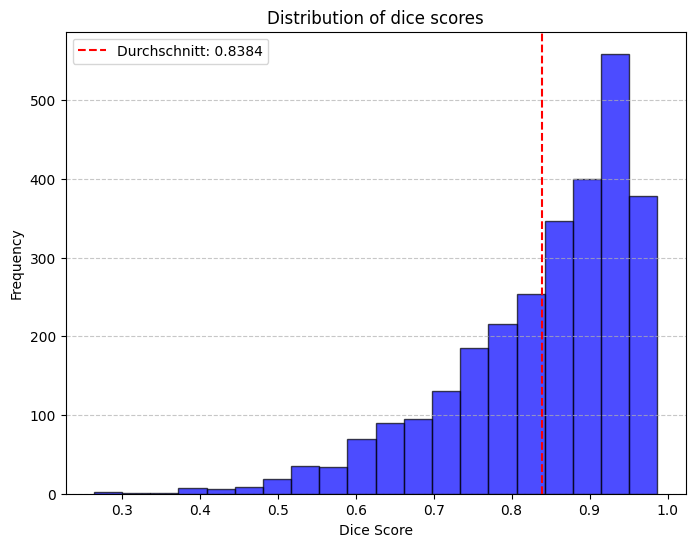

In [3]:
import matplotlib.pyplot as plt

# Ergebnisse speichern und analysieren
if dice_scores:
    # Ergebnisse in CSV speichern
    with open("data\\upper_airways\\dice_scores_18_06.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm erstellen
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of dice scores')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Durchschnitt im Histogramm markieren
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern und anzeigen
    plt.savefig('data\\upper_airways\\dice_score_histogram_18_06.png')
    plt.show()
else:
    logging.info("Keine Dice Scores berechnet!")


2025-09-04 15:59:02,208 - INFO - atm_001_slice_2_Grund_truth_mask.png: HD=1.742 mm | HD95=1.503 mm (spacing=(0.435546875, 0.435546875))
2025-09-04 15:59:02,253 - INFO - atm_001_slice_7_Grund_truth_mask.png: HD=1.848 mm | HD95=0.974 mm (spacing=(0.435546875, 0.435546875))
2025-09-04 15:59:02,267 - INFO - atm_001_slice_0_Grund_truth_mask.png: HD=1.742 mm | HD95=1.742 mm (spacing=(0.435546875, 0.435546875))
2025-09-04 15:59:02,277 - INFO - atm_001_slice_5_Grund_truth_mask.png: HD=1.742 mm | HD95=0.974 mm (spacing=(0.435546875, 0.435546875))
2025-09-04 15:59:02,309 - INFO - atm_001_slice_1_Grund_truth_mask.png: HD=2.178 mm | HD95=1.541 mm (spacing=(0.435546875, 0.435546875))
2025-09-04 15:59:02,365 - INFO - atm_001_slice_4_Grund_truth_mask.png: HD=1.742 mm | HD95=1.232 mm (spacing=(0.435546875, 0.435546875))
2025-09-04 15:59:02,424 - INFO - atm_001_slice_3_Grund_truth_mask.png: HD=1.742 mm | HD95=0.974 mm (spacing=(0.435546875, 0.435546875))
2025-09-04 15:59:02,669 - INFO - atm_001_slice_6

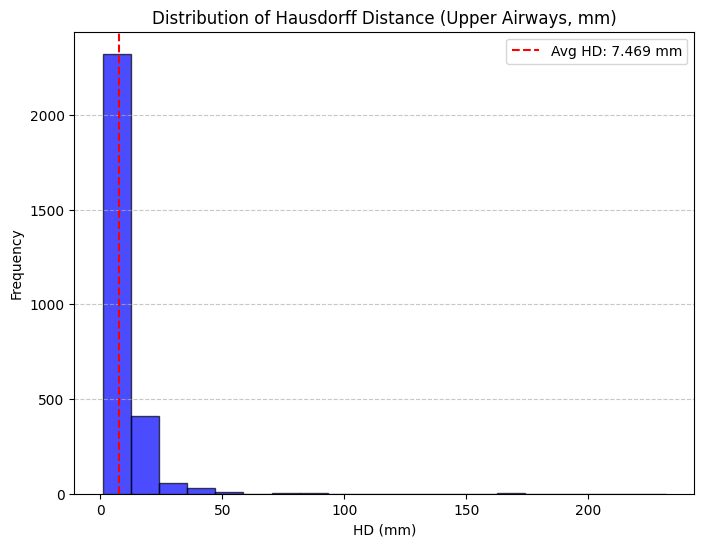

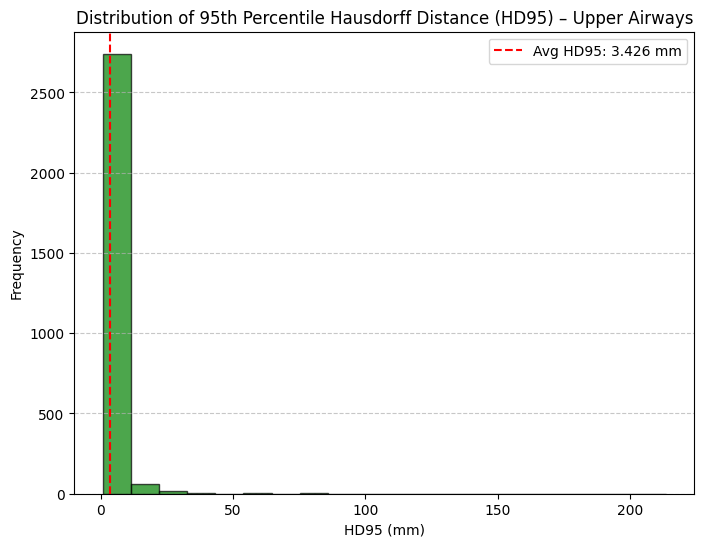

In [1]:
import os
import numpy as np
import cv2
import logging
import csv
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from scipy import ndimage as ndi
import nibabel as nib

# ---------------- Logging ----------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ---------------- Pfade ----------------
mask_png_folder = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_masks_png"
segmentation_results_folder = r"F:\Rawan_Masterarbeit\data\upper_airways\segmentation_results_18_06"
nii_root = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_images"   # << ggf. anpassen

# ---------------- Spacing-Cache ----------------
_spacing_cache = {}  # base_name -> (dy, dx) in mm

def _get_spacing_dy_dx(base_name: str):
    """Hole (dy, dx) aus <nii_root>/<base_name>.nii.gz (Fallback auf .nii)."""
    if base_name in _spacing_cache:
        return _spacing_cache[base_name]
    candidates = [os.path.join(nii_root, f"{base_name}.nii.gz"),
                  os.path.join(nii_root, f"{base_name}.nii")]
    nii_path = next((p for p in candidates if os.path.exists(p)), None)
    if nii_path is None:
        logging.warning(f"Kein NIfTI für {base_name} gefunden → spacing=(1.0,1.0)")
        _spacing_cache[base_name] = (1.0, 1.0)
        return _spacing_cache[base_name]
    nii = nib.load(nii_path)
    zooms = nii.header.get_zooms()  # (dx, dy, dz, ...)
    dx, dy = float(zooms[0]), float(zooms[1])
    _spacing_cache[base_name] = (dy, dx)  # EDT erwartet (dy, dx)
    return _spacing_cache[base_name]

# ---------------- HD/HD95 Hilfsfunktionen ----------------
def _bin2d(a: np.ndarray) -> np.ndarray:
    if a.ndim != 2:
        raise ValueError("Erwarte 2D-Maske.")
    return (a > 0).astype(np.uint8)

def _surface(mask: np.ndarray) -> np.ndarray:
    if mask.sum() == 0:
        return mask.astype(bool)
    eroded = ndi.binary_erosion(mask, iterations=1, border_value=0)
    return mask.astype(bool) & (~eroded)

def _surface_distances_2d(A: np.ndarray, B: np.ndarray, spacing) -> np.ndarray:
    if B.sum() == 0:
        d = np.full(A.shape, np.inf, dtype=float)
    else:
        d = ndi.distance_transform_edt(~B.astype(bool), sampling=spacing)
    return d[_surface(A)]

def hausdorff_2d(mask1: np.ndarray, mask2: np.ndarray, spacing, percentile=None) -> float:
    a = _bin2d(mask1); b = _bin2d(mask2)
    if a.sum() == 0 and b.sum() == 0:
        return 0.0
    if a.sum() == 0 or b.sum() == 0:
        return float("inf")
    d_ab = _surface_distances_2d(a, b, spacing)
    d_ba = _surface_distances_2d(b, a, spacing)
    all_d = np.concatenate([d_ab, d_ba])
    if all_d.size == 0:
        return 0.0
    return float(np.max(all_d) if percentile is None else np.percentile(all_d, percentile))

# ---------------- Einzeldatei-Verarbeitung ----------------
def process_single_file_hd(mask_filename: str):
    """
    Dateimuster:
      - Segmentierung:   <base>.nii.gz_slice_<N>_segmentation.png
      - Ground Truth:    <base>_slice_<N>_Grund_truth_mask.png
      - (kein -1 Offset!)
    """
    base_name = mask_filename.split("_slice_")[0]         # z.B. "atm_001"
    slice_number = mask_filename.split("_slice_")[-1].split("_")[0]

    seg_name = f"{base_name}.nii.gz_slice_{slice_number}_segmentation.png"
    gt_name  = f"{base_name}_slice_{slice_number}_Grund_truth_mask.png"

    seg_path = os.path.join(segmentation_results_folder, seg_name)
    gt_path  = os.path.join(mask_png_folder, gt_name)

    if not (os.path.exists(seg_path) and os.path.exists(gt_path)):
        logging.warning(f"Segmentationsdatei oder Ground-Truth fehlt für {mask_filename}")
        return None

    spacing = _get_spacing_dy_dx(base_name)

    s_img = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
    gt_img = cv2.imread(gt_path,  cv2.IMREAD_GRAYSCALE)
    if s_img is None or gt_img is None:
        logging.error(f"Fehler beim Laden: {mask_filename}")
        return None

    # ggf. Shape angleichen (Nearest)
    if s_img.shape != gt_img.shape:
        logging.warning(f"Resize {base_name} slice {slice_number}: {s_img.shape} -> {gt_img.shape}")
        s_img = cv2.resize(s_img, (gt_img.shape[1], gt_img.shape[0]), interpolation=cv2.INTER_NEAREST)

    s_bin = (s_img > 0).astype(np.uint8)
    gt_bin = (gt_img > 0).astype(np.uint8)

    hd   = hausdorff_2d(s_bin, gt_bin, spacing=spacing, percentile=None)
    hd95 = hausdorff_2d(s_bin, gt_bin, spacing=spacing, percentile=95)

    logging.info(f"{mask_filename}: HD={hd:.3f} mm | HD95={hd95:.3f} mm (spacing={spacing})")
    return mask_filename, hd, hd95

# ---------------- Parallelisieren & Sammeln ----------------
results = []
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(process_single_file_hd, fn)
        for fn in os.listdir(mask_png_folder)
        if fn.endswith(".png")
    ]
    results = [f.result() for f in futures if f.result() is not None]

# ---------------- Speichern & Visualisieren ----------------
out_csv = r"F:\Rawan_Masterarbeit\data\upper_airways\hausdorff_results_upper_airways.csv"
if results:
    with open(out_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Maskenname", "Hausdorff_mm", "HD95_mm"])
        writer.writerows(results)
    logging.info(f"CSV gespeichert: {out_csv}")

    # Werte für Plots (∞ ausschließen)
    hd_vals   = [r[1] for r in results if np.isfinite(r[1])]
    hd95_vals = [r[2] for r in results if np.isfinite(r[2])]

    avg_hd   = np.mean(hd_vals)   if hd_vals   else None
    avg_hd95 = np.mean(hd95_vals) if hd95_vals else None

    # HD Histogramm
    if hd_vals:
        plt.figure(figsize=(8, 6))
        plt.hist(hd_vals, bins=20, color='blue', alpha=0.7, edgecolor='black')
        plt.title('Distribution of Hausdorff Distance (Upper Airways, mm)')
        plt.xlabel('HD (mm)'); plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        if avg_hd is not None:
            plt.axvline(avg_hd, color='red', linestyle='dashed', linewidth=1.5,
                        label=f'Avg HD: {avg_hd:.3f} mm')
            plt.legend()
        plt.savefig(r"F:\Rawan_Masterarbeit\data\upper_airways\hausdorff_hist_upper_airways.png",
                    dpi=150, bbox_inches='tight')
        plt.show()

    # HD95 Histogramm
    if hd95_vals:
        plt.figure(figsize=(8, 6))
        plt.hist(hd95_vals, bins=20, color='green', alpha=0.7, edgecolor='black')
        plt.title('Distribution of 95th Percentile Hausdorff Distance (HD95) – Upper Airways')
        plt.xlabel('HD95 (mm)'); plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        if avg_hd95 is not None:
            plt.axvline(avg_hd95, color='red', linestyle='dashed', linewidth=1.5,
                        label=f'Avg HD95: {avg_hd95:.3f} mm')
            plt.legend()
        plt.savefig(r"F:\Rawan_Masterarbeit\data\upper_airways\hausdorff95_hist_upper_airways.png",
                    dpi=150, bbox_inches='tight')
        plt.show()
else:
    logging.info("Keine HD/HD95-Werte berechnet!")


2025-09-04 16:25:12,929 - INFO - atm_001_slice_4: IoU = 0.8670
2025-09-04 16:25:12,960 - INFO - atm_001_slice_0: IoU = 0.7913
2025-09-04 16:25:12,945 - INFO - atm_001_slice_1: IoU = 0.7967
2025-09-04 16:25:12,945 - INFO - atm_001_slice_3: IoU = 0.8730
2025-09-04 16:25:12,945 - INFO - atm_001_slice_2: IoU = 0.8693
2025-09-04 16:25:13,049 - INFO - atm_001_slice_8: IoU = 0.7511
2025-09-04 16:25:13,065 - INFO - atm_001_slice_5: IoU = 0.8960
2025-09-04 16:25:13,101 - INFO - atm_001_slice_9: IoU = 0.8049
2025-09-04 16:25:13,120 - INFO - atm_001_slice_7: IoU = 0.8431
2025-09-04 16:25:13,213 - INFO - atm_001_slice_14: IoU = 0.9003
2025-09-04 16:25:13,146 - INFO - atm_001_slice_10: IoU = 0.8450
2025-09-04 16:25:13,161 - INFO - atm_001_slice_12: IoU = 0.8685
2025-09-04 16:25:13,131 - INFO - atm_001_slice_6: IoU = 0.8475
2025-09-04 16:25:13,233 - INFO - atm_001_slice_11: IoU = 0.7512
2025-09-04 16:25:13,238 - INFO - atm_001_slice_16: IoU = 0.8164
2025-09-04 16:25:13,311 - INFO - atm_001_slice_13:

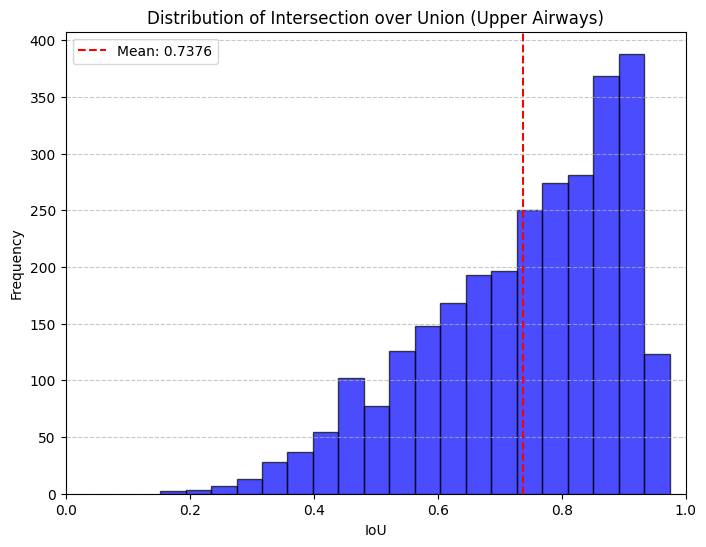

2025-09-04 16:26:07,367 - INFO - IoU-Histogramm gespeichert: F:\Rawan_Masterarbeit\data\upper_airways\iou_hist_upper_airways.png


In [2]:
import os
import numpy as np
import cv2
import logging
import csv
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# ---------------- Logging ----------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ---------------- Pfade ----------------
mask_png_folder = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_masks_png"
segmentation_results_folder = r"F:\Rawan_Masterarbeit\data\upper_airways\segmentation_results_18_06"

# ---------------- IoU ----------------
def iou_2d(a: np.ndarray, b: np.ndarray) -> float:
    """
    Intersection over Union für 2D-Binärmasken.
    IoU = |A ∩ B| / |A ∪ B|
    Sonderfall: beide leer -> IoU = 1.0
    """
    a = (a > 0).astype(np.uint8)
    b = (b > 0).astype(np.uint8)
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    if union == 0:
        return 1.0
    return inter / union

# ---------------- Einzeldatei-Verarbeitung ----------------
def process_single_file_iou(mask_filename: str):
    """
    Erwartet:
      - Segmentierung: <base>.nii.gz_slice_<N>_segmentation.png
      - Ground Truth:  <base>_slice_<N>_Grund_truth_mask.png
    (kein -1 Offset)
    """
    base_name = mask_filename.split("_slice_")[0]
    slice_number = mask_filename.split("_slice_")[-1].split("_")[0]

    seg_name = f"{base_name}.nii.gz_slice_{slice_number}_segmentation.png"
    gt_name  = f"{base_name}_slice_{slice_number}_Grund_truth_mask.png"

    seg_path = os.path.join(segmentation_results_folder, seg_name)
    gt_path  = os.path.join(mask_png_folder, gt_name)

    if not (os.path.exists(seg_path) and os.path.exists(gt_path)):
        logging.warning(f"Segmentationsdatei oder Ground Truth fehlt: {seg_name} / {gt_name}")
        return None

    try:
        seg_img = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
        gt_img  = cv2.imread(gt_path,  cv2.IMREAD_GRAYSCALE)
        if seg_img is None or gt_img is None:
            logging.error(f"Fehler beim Laden: {seg_path} oder {gt_path}")
            return None

        # Falls Größen abweichen, auf GT bringen (nearest, da Labelbild)
        if seg_img.shape != gt_img.shape:
            logging.warning(f"Resize {base_name} slice {slice_number}: {seg_img.shape} -> {gt_img.shape}")
            seg_img = cv2.resize(seg_img, (gt_img.shape[1], gt_img.shape[0]), interpolation=cv2.INTER_NEAREST)

        val = iou_2d(seg_img, gt_img)
        logging.info(f"{base_name}_slice_{slice_number}: IoU = {val:.4f}")
        return f"{base_name}_slice_{slice_number}", float(val)

    except Exception as e:
        logging.error(f"Fehler bei {mask_filename}: {e}")
        return None

# ---------------- Parallelisieren & Sammeln ----------------
iou_results = []
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(process_single_file_iou, fn)
        for fn in os.listdir(mask_png_folder)
        if fn.endswith(".png")
    ]
    iou_results = [f.result() for f in futures if f.result() is not None]

# ---------------- Speichern & Visualisieren ----------------
out_csv = r"F:\Rawan_Masterarbeit\data\upper_airways\iou_results_18_06.csv"
if iou_results:
    # CSV
    with open(out_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Slice", "IoU"])
        writer.writerows(iou_results)
    logging.info(f"CSV gespeichert: {out_csv}")

    # Histogramm
    iou_vals = [r[1] for r in iou_results]
    avg_iou = float(np.mean(iou_vals)) if iou_vals else None

    plt.figure(figsize=(8, 6))
    plt.hist(iou_vals, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Intersection over Union (Upper Airways)')
    plt.xlabel('IoU'); plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim(0, 1); plt.ylim(bottom=0)
    if avg_iou is not None:
        plt.axvline(avg_iou, color='red', linestyle='dashed', linewidth=1.5,
                    label=f'Mean: {avg_iou:.4f}')
        plt.legend()

    plot_path = r"F:\Rawan_Masterarbeit\data\upper_airways\iou_hist_upper_airways.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    logging.info(f"IoU-Histogramm gespeichert: {plot_path}")
else:
    logging.info("Keine IoU-Werte berechnet!")


2025-09-04 16:31:14,663 - WARNING - Kein NIfTI für atm_001 gefunden → spacing=(1.0,1.0)
2025-09-04 16:31:14,666 - WARNING - Kein NIfTI für atm_001 gefunden → spacing=(1.0,1.0)
2025-09-04 16:31:14,673 - WARNING - Kein NIfTI für atm_001 gefunden → spacing=(1.0,1.0)
2025-09-04 16:31:14,689 - WARNING - Kein NIfTI für atm_001 gefunden → spacing=(1.0,1.0)
2025-09-04 16:31:14,689 - WARNING - Kein NIfTI für atm_001 gefunden → spacing=(1.0,1.0)
2025-09-04 16:31:14,704 - WARNING - Kein NIfTI für atm_001 gefunden → spacing=(1.0,1.0)
2025-09-04 16:31:14,704 - WARNING - Kein NIfTI für atm_001 gefunden → spacing=(1.0,1.0)
2025-09-04 16:31:15,916 - INFO - atm_001_slice_1: Surface Dice (1.0 mm) = 0.6250 (spacing=(1.0, 1.0))
2025-09-04 16:31:16,039 - INFO - atm_001_slice_6: Surface Dice (1.0 mm) = 0.6681 (spacing=(1.0, 1.0))
2025-09-04 16:31:16,076 - INFO - atm_001_slice_7: Surface Dice (1.0 mm) = 0.7288 (spacing=(1.0, 1.0))
2025-09-04 16:31:16,066 - INFO - atm_001_slice_3: Surface Dice (1.0 mm) = 0.71

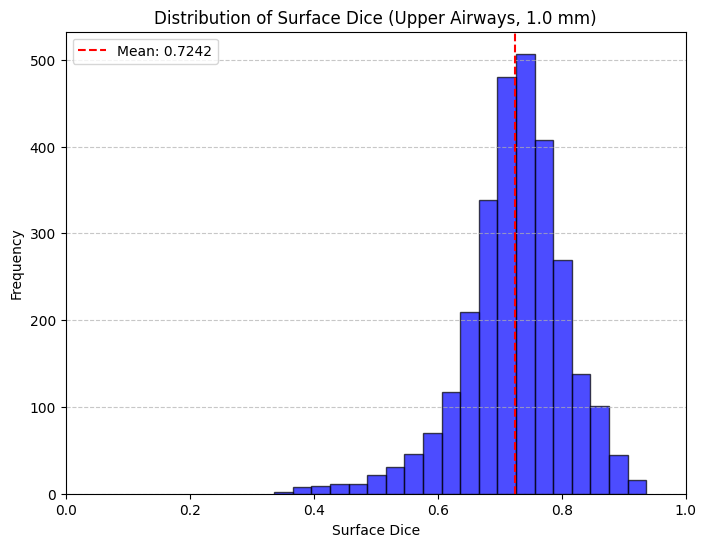

2025-09-04 16:40:09,330 - INFO - Surface-Dice-Histogramm gespeichert: F:\Rawan_Masterarbeit\data\upper_airways\surface_dice_hist_1_0mm.png


In [3]:
import os
import numpy as np
import cv2
import logging
import csv
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from scipy import ndimage as ndi
import nibabel as nib

# ---------------- Logging ----------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ---------------- Pfade ----------------
mask_png_folder = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_masks_png"
segmentation_results_folder = r"F:\Rawan_Masterarbeit\data\upper_airways\segmentation_results_18_06"
nii_root = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_images"  # NIfTIs liegen hier

# ---------------- Parameter ----------------
tolerance_mm = 1.0  # Surface-Dice Toleranz (z.B. 1.0 oder 2.0 mm)

# ---------------- Spacing-Cache ----------------
_spacing_cache = {}  # base_name -> (dy, dx) in mm

def _get_spacing_dy_dx(base_name: str):
    """Hole (dy, dx) in mm aus <nii_root>/<base_name>.nii(.gz); Fallback (1,1)."""
    if base_name in _spacing_cache:
        return _spacing_cache[base_name]
    for ext in (".nii.gz", ".nii"):
        p = os.path.join(nii_root, base_name + ext)
        if os.path.exists(p):
            nii = nib.load(p)
            dx, dy = float(nii.header.get_zooms()[0]), float(nii.header.get_zooms()[1])  # (dx,dy, ...)
            _spacing_cache[base_name] = (dy, dx)  # EDT erwartet (dy,dx)
            return _spacing_cache[base_name]
    logging.warning(f"Kein NIfTI für {base_name} gefunden → spacing=(1.0,1.0)")
    _spacing_cache[base_name] = (1.0, 1.0)
    return _spacing_cache[base_name]

# ---------------- Surface-Dice Hilfsfunktionen ----------------
def _bin2d(a: np.ndarray) -> np.ndarray:
    if a.ndim != 2:
        raise ValueError("Erwarte 2D-Maske.")
    return (a > 0).astype(np.uint8)

def _surface(mask: np.ndarray) -> np.ndarray:
    if mask.sum() == 0:
        return mask.astype(bool)
    eroded = ndi.binary_erosion(mask, iterations=1, border_value=0)
    return mask.astype(bool) & (~eroded)

def surface_dice_2d(pred: np.ndarray, gt: np.ndarray, spacing, tol_mm: float) -> float:
    """
    Anteil der Oberflächenpunkte beider Masken, deren Abstand zur jeweils anderen
    Oberfläche ≤ tol_mm ist. Ergebnis in [0,1].
    """
    p = _bin2d(pred); g = _bin2d(gt)
    ps = _surface(p); gs = _surface(g)

    # Sonderfälle
    if p.sum() == 0 and g.sum() == 0:
        return 1.0
    if ps.sum() == 0 and gs.sum() == 0:
        return 1.0
    if ps.sum() == 0 or gs.sum() == 0:
        return 0.0

    d_to_g = ndi.distance_transform_edt(~g.astype(bool), sampling=spacing)
    d_to_p = ndi.distance_transform_edt(~p.astype(bool), sampling=spacing)

    p_ok = (d_to_g[ps] <= tol_mm).sum()
    g_ok = (d_to_p[gs] <= tol_mm).sum()
    return (p_ok + g_ok) / (ps.sum() + gs.sum())

# ---------------- Einzeldatei-Verarbeitung ----------------
def process_single_file_surface_dice(mask_filename: str):
    """
    Erwartet:
      - Segmentierung: <base>.nii.gz_slice_<N>_segmentation.png
      - Ground Truth:  <base>_slice_<N>_Grund_truth_mask.png
    """
    base_name = mask_filename.split("_slice_")[0]
    slice_number = mask_filename.split("_slice_")[-1].split("_")[0]

    seg_name = f"{base_name}.nii.gz_slice_{slice_number}_segmentation.png"
    gt_name  = f"{base_name}_slice_{slice_number}_Grund_truth_mask.png"

    seg_path = os.path.join(segmentation_results_folder, seg_name)
    gt_path  = os.path.join(mask_png_folder, gt_name)

    if not (os.path.exists(seg_path) and os.path.exists(gt_path)):
        logging.warning(f"Segmentationsdatei oder Ground Truth fehlt: {seg_name} / {gt_name}")
        return None

    spacing = _get_spacing_dy_dx(base_name)

    seg_img = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
    gt_img  = cv2.imread(gt_path,  cv2.IMREAD_GRAYSCALE)
    if seg_img is None or gt_img is None:
        logging.error(f"Fehler beim Laden: {seg_path} oder {gt_path}")
        return None

    if seg_img.shape != gt_img.shape:
        logging.warning(f"Resize {base_name} slice {slice_number}: {seg_img.shape} -> {gt_img.shape}")
        seg_img = cv2.resize(seg_img, (gt_img.shape[1], gt_img.shape[0]), interpolation=cv2.INTER_NEAREST)

    sd = surface_dice_2d(seg_img, gt_img, spacing=spacing, tol_mm=tolerance_mm)
    logging.info(f"{base_name}_slice_{slice_number}: Surface Dice ({tolerance_mm} mm) = {sd:.4f} (spacing={spacing})")
    return f"{base_name}_slice_{slice_number}", float(sd)

# ---------------- Parallelisieren & Sammeln ----------------
sd_results = []
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(process_single_file_surface_dice, fn)
        for fn in os.listdir(mask_png_folder)
        if fn.endswith(".png")
    ]
    sd_results = [f.result() for f in futures if f.result() is not None]

# ---------------- Speichern & Visualisieren ----------------
out_csv = rf"F:\Rawan_Masterarbeit\data\upper_airways\surface_dice_{str(tolerance_mm).replace('.','_')}mm_results.csv"
if sd_results:
    with open(out_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Slice", f"SurfaceDice_{tolerance_mm}mm"])
        writer.writerows(sd_results)
    logging.info(f"CSV gespeichert: {out_csv}")

    sd_vals = [r[1] for r in sd_results]
    avg_sd = float(np.mean(sd_vals)) if sd_vals else None

    plt.figure(figsize=(8, 6))
    plt.hist(sd_vals, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of Surface Dice (Upper Airways, {tolerance_mm} mm)')
    plt.xlabel('Surface Dice'); plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim(0, 1); plt.ylim(bottom=0)
    if avg_sd is not None:
        plt.axvline(avg_sd, color='red', linestyle='dashed', linewidth=1.5,
                    label=f'Mean: {avg_sd:.4f}')
        plt.legend()

    plot_path = rf"F:\Rawan_Masterarbeit\data\upper_airways\surface_dice_hist_{str(tolerance_mm).replace('.','_')}mm.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    logging.info(f"Surface-Dice-Histogramm gespeichert: {plot_path}")
else:
    logging.info("Keine Surface-Dice-Werte berechnet!")


In [ ]:
import os
import numpy as np
import cv2
import logging
import csv
import matplotlib.pyplot as plt  # Hier sicherstellen, dass matplotlib.pyplot importiert ist
from concurrent.futures import ThreadPoolExecutor

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit den Masken und Segmentierungen
mask_png_folder = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_masks_png"
segmentation_results_folder = r"F:\Rawan_Masterarbeit\data\upper_airways\segmentation_results_18_06"

# Funktion zur Berechnung des Dice Scores
def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    if np.sum(mask1) + np.sum(mask2) == 0:
        return 1.0  # Sonderfall: Beide Masken sind komplett leer
    dice = (2. * intersection) / (np.sum(mask1) + np.sum(mask2))
    return dice

# Funktion zur Verarbeitung einer einzelnen Datei
def process_single_file(mask_filename):
    base_name = mask_filename.split("_slice_")[0]
    slice_number = mask_filename.split("_slice_")[-1].split("_")[0]
    
    # Slice-Index nicht konvertieren, um den Slice korrekt zu matchen
    segmentation_filename = f"{base_name}.nii.gz_slice_{slice_number}_segmentation.png"
    ground_truth_filename = f"{base_name}_slice_{slice_number}_Grund_truth_mask.png"

    # Pfade für Segmentierung und Grundtruth-Maske
    mask_png_path = os.path.join(mask_png_folder, mask_filename)
    segmentation_path = os.path.join(segmentation_results_folder, segmentation_filename)
    ground_truth_path = os.path.join(mask_png_folder, ground_truth_filename)

    if os.path.exists(segmentation_path) and os.path.exists(ground_truth_path):
        try:
            # Masken laden
            mask_png = cv2.imread(mask_png_path, cv2.IMREAD_GRAYSCALE)
            segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)
            ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

            # Sicherstellen, dass alle Masken binär sind (0 und 1)
            mask_png = (mask_png > 0).astype(np.uint8)
            segmentation = (segmentation > 0).astype(np.uint8)
            ground_truth = (ground_truth > 0).astype(np.uint8)

            # Dice Score berechnen (zwischen Segmentierung und Grundtruth)
            dice_segmentation_gt = dice_score(segmentation, ground_truth)
            logging.info(f"{mask_filename}: Dice Score zwischen Segmentierung und Grundtruth = {dice_segmentation_gt:.4f}")
            
            return mask_filename, dice_segmentation_gt
        except Exception as e:
            logging.error(f"Fehler beim Verarbeiten von {mask_filename}: {e}")
            return None
    else:
        logging.warning(f"Segmentationsdatei oder Grundtruth-Maske für {mask_filename} nicht gefunden!")
        return None

# Parallelisierte Verarbeitung
dice_scores = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, mask_filename) for mask_filename in os.listdir(mask_png_folder) if mask_filename.endswith(".png")]
    dice_scores = [future.result() for future in futures if future.result() is not None]
'''
# Ergebnisse speichern und analysieren
if dice_scores:
    # Ergebnisse in CSV speichern
    with open("data\\upper_airways\\dice_scores_18_06.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm erstellen
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of dice scores')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Durchschnitt im Histogramm markieren
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Durchschnitt: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern und anzeigen
    plt.savefig('data\\upper_airways\\dice_score_histogram_18_06.png')
    plt.show()
else:
    logging.info("Keine Dice Scores berechnet!")
'''

2025-08-18 16:41:03,466 - INFO - atm_001_slice_7_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.9149
2025-08-18 16:41:03,498 - INFO - atm_001_slice_1_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.8868
2025-08-18 16:41:03,513 - INFO - atm_001_slice_0_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.8835
2025-08-18 16:41:03,517 - INFO - atm_001_slice_4_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.9288
2025-08-18 16:41:03,538 - INFO - atm_001_slice_6_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.9175
2025-08-18 16:41:03,578 - INFO - atm_001_slice_5_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.9452
2025-08-18 16:41:03,644 - INFO - atm_001_slice_10_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.9160
2025-08-18 16:41:03,684 - INFO - atm_001_slice_2_Grund_truth_mask.png: Dice Score zwischen Segme

In [ ]:
# Ergebnisse speichern und analysieren
if dice_scores:
    # Ergebnisse in CSV speichern
    with open("data\\upper_airways\\dice_scores_18_06.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm erstellen
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of dice scores')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Durchschnitt im Histogramm markieren
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Durchschnitt: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern und anzeigen
    plt.savefig('data\\upper_airways\\dice_score_histogram_MedSAM_upperairways.png')
    plt.show()
else:
    logging.info("Keine Dice Scores berechnet!")
